In this notebook we will be covering following topics to cover insights in data and treat variables for model building - 
1. Data Cleaning
2. Univariate Analysis 
3. Multivariate Analysis

In [28]:
# Load Packages
#!pip install requests
import requests
import json
import re
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None) 
#!pip install pandas
import os # use this to access your environment variables
#!pip install plotly
import plotly.express as px
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
#!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install scipy
from scipy.stats import ttest_ind
import sqlite3
from ast import literal_eval

#!pip install nbformat --upgrade

# Yelp Data Cleaning
We will be covering following steps - 
1. Merge all the 3 datasets to make a single dataframe
2. Remove duplicates and drop redundant columns
3. Change data types (if required) 
4. Treat outliers and missing values
4. Feature engineering - Create new features for better modeling

In [39]:
# Merge Datasets

yelp_df1 = pd.read_csv(r'.\Data\Yelp_Lat_Long_Matching_Dataset_Part1.csv')
yelp_df2 = pd.read_csv(r'.\Data\Yelp_Lat_Long_Matching_Dataset_Part2.csv')
yelp_df3 = pd.read_csv(r'.\Data\Yelp_Lat_Long_Matching_Dataset_Part3.csv')


yelp_df = pd.concat([yelp_df1, yelp_df2, yelp_df3], axis = 0)
yelp_df.head(25)


yelp_df.to_csv(r'.\Data\Yelp_Merged_df.csv', index = False)
yelp_df.shape
yelp_df.head(5)

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,price,phone,display_phone,distance,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address,Latitude,Longitude
0,WHHt_Jb8Tgidn9mW7oDnIg,la-coïncidence-paris-4,La Coïncidence,https://s3-media3.fl.yelpcdn.com/bphoto/JIS7KF...,False,https://www.yelp.com/biz/la-co%C3%AFncidence-p...,509,"[{'alias': 'french', 'title': 'French'}]",4.5,[],€€,3.314756e+10,+33 1 47 55 96 44,674.583885,48.868105,2.284365,15 rue Mesnil,NaN,NaN,Paris,75116.0,FR,75.0,"['15 rue Mesnil', '75116 Paris', 'France']",48.865983,2.275725
1,9Dg5IhmhqeQhriJfMeNZ3g,le-poincaré-paris-2,Le Poincaré,https://s3-media1.fl.yelpcdn.com/bphoto/sye-BE...,False,https://www.yelp.com/biz/le-poincar%C3%A9-pari...,154,"[{'alias': 'french', 'title': 'French'}, {'ali...",4.0,[],€€,3.314505e+10,+33 1 45 05 46 10,796.383746,48.865057,2.286521,22 avenue Raymond Poincaré,NaN,NaN,Paris,75116.0,FR,75.0,"['22 avenue Raymond Poincaré', '75116 Paris', ...",48.865983,2.275725
2,-Df0MVdm7yOvsVX8IfB20Q,sgabetti-paris,Sgabetti,https://s3-media3.fl.yelpcdn.com/bphoto/f1ecZ6...,False,https://www.yelp.com/biz/sgabetti-paris?adjust...,40,"[{'alias': 'italian', 'title': 'Italian'}]",4.5,[],€€,3.314704e+10,+33 1 47 04 09 27,581.102661,48.865831,2.283666,15 rue Sablons,NaN,NaN,Paris,75016.0,FR,75.0,"['15 rue Sablons', '75016 Paris', 'France']",48.865983,2.275725
3,Xip_9jPAlsSd1AY5FW-TAw,hiramatsu-paris,Hiramatsu,https://s3-media3.fl.yelpcdn.com/bphoto/BGA26O...,False,https://www.yelp.com/biz/hiramatsu-paris?adjus...,32,"[{'alias': 'french', 'title': 'French'}]",4.5,[],€€€€,3.315681e+10,+33 1 56 81 08 80,867.996120,48.865070,2.287510,52 rue de Longchamp,NaN,NaN,Paris,75016.0,FR,75.0,"['52 rue de Longchamp', '75016 Paris', 'France']",48.865983,2.275725
4,AOdAHOD8oghNdf1i7WpWzA,bon-paris-6,Bon,https://s3-media2.fl.yelpcdn.com/bphoto/kHvcij...,False,https://www.yelp.com/biz/bon-paris-6?adjust_cr...,120,"[{'alias': 'french', 'title': 'French'}, {'ali...",4.0,[],€€€€,3.314073e+10,+33 1 40 72 70 00,646.787634,48.860180,2.274980,25 rue de la Pompe,NaN,NaN,Paris,75116.0,FR,75.0,"['25 rue de la Pompe', '75116 Paris', 'France']",48.865983,2.275725


In [ ]:
# Drop duplicates - Unique on Id
yelp_df = yelp_df.drop_duplicates(subset='id')
yelp_df.shape

In [ ]:
# Extract additional features like restaurant cuisine

yelp_df['categories2'] = yelp_df['categories'].apply(literal_eval)
yelp_df.info()

# Function to extract titles from the list of dictionaries
def extract_title(category_list, position):
    if position < len(category_list):
        return category_list[position].get('title', '')
    else:
        return ''

# Create new columns 'title_0', 'title_1', ..., 'title_4'
for i in range(5):
    yelp_df[f'title_{i}'] = yelp_df['categories2'].apply(lambda x: extract_title(x, i))

    #Function to parse and extract category titles
def extract_categories(cat_string):
    try:
        cat_list = json.loads(cat_string.replace("'", "\""))
        return [cat['title'] for cat in cat_list]
    except json.decoder.JSONDecodeError:
        return []
    
# Apply the function to parse categories in Yelp dataframe
yelp_df['parsed_categories'] = yelp_df['categories'].apply(extract_categories)


yelp_df['yelp_category'] = yelp_df['parsed_categories'].apply(lambda x: '-'.join(x))
yelp_df.head(5)


In [11]:
# Drop redundant columns - alias, image_url, is_closed, url, transactions, phone, display_phone, location.address1,	
# location.address2, location.address3,	location.country, location.state	location.display_address,
# location.zip_code
columns_to_drop = [
    'alias', 'image_url', 'is_closed', 'url', 'categories', 'transactions', 
    'phone', 'display_phone', 'location.address1', 'location.address2',
    'location.address3', 'location.city', 'location.country', 'location.state', 
    'location.display_address',  'categories2', 'parsed_categories'
]

yelp_df = yelp_df.drop(columns=columns_to_drop)

In [12]:
# Create a Price Category column

yelp_df['restaurant_price_category'] = yelp_df['price'].apply(lambda x: x.count('€') if pd.notna(x) else 1)
yelp_df.drop(columns = ['price'], inplace = True)

In [ ]:
# Check the data types
yelp_df.info()

In [14]:
# Convert the specified columns to categorical

mode_zipcode = yelp_df['location.zip_code'].mode()[0]  # Calculate the mode
yelp_df['location.zip_code'].fillna(mode_zipcode, inplace=True)

# Convert the float column to integers
yelp_df['location.zip_code'] = yelp_df['location.zip_code'].astype(int)
columns_to_convert = ['location.zip_code', 'restaurant_price_category']
yelp_df[columns_to_convert] = yelp_df[columns_to_convert].astype('category')

In [ ]:
# Check for outliers
yelp_df.describe(include = 'all') # Later we will be using boxplots to investigate the outliers further

# Check for missing values 
yelp_df.isna().sum() # Zip code has 6 blank values 
yelp_df['location.zip_code'] = yelp_df['location.zip_code'].fillna(yelp_df['location.zip_code'].mode()[0])
yelp_df.isna().sum() 


In [ ]:
# Rename columns
yelp_df.head(5)
yelp_df.columns
yelp_df.rename(columns={'id':'Restaurant_ID', 'name':'Restaurant_Name', 'review_count':'Review_Count', 
                        'rating':'Restaurant_Rating', 'distance': 'Distance_Bike_Station',
                        'coordinates.latitude': 'Restaurant_Latitude',
                        'coordinates.longitude': 'Restaurant_Longitude',
                        'location.zip_code': 'Restaurant_Zip_code',                       
                        'title_0': 'Cuisine_Category_1',
                        'title_1': 'Cuisine_Category_2',
                        'title_2': 'Cuisine_Category_3',
                        'title_3': 'Cuisine_Category_4',
                        'title_4': 'Cuisine_Category_5',
                        'yelp_category': 'All_Cuisine_Category',
                        'restaurant_price_category': 'Yelp_Price_Category'}, inplace=True)
yelp_df.head(5)

In [ ]:
yelp_df.info()

# City Bike Dataframe
In this notebook we will be repeating the data cleaning steps as done for Yelp (listed above)

In [ ]:
# Clean the Bike Data Frame
city_bike_df = pd.read_csv(r'Data\City_Bike_Paris_Data_9th.csv')
city_bike_df.head(5)

# Data cleaning steps
# Drop redundant columns - id, City, Country, Station_Id,	Station_Name, Timestamp, Total_Available_Free_Bikes,	Total_Available_EBikes,	Total_Available_Empty_Slots, Unnamed: 12
# Check for unique row count
# Check Data Types
# Check for missing values and outliers
# Rename Columns


In [19]:
# Drop non relevant columns

city_bike_df.drop(columns = ['id', 'City', 'Country', 'Station_Id',	'Station_Name', 'Timestamp', 
                             'Total_Available_Free_Bikes',	'Total_Available_EBikes',	
                             'Total_Available_Empty_Slots', 'Unnamed: 12'], inplace = True)

In [ ]:
# Rename Columns
city_bike_df.head(5)
city_bike_df.rename(columns={'Total_Available_Slots':'Total_Available_Bike_Slots'}, inplace=True)
city_bike_df.columns

In [ ]:
# Check unique count of rows
city_bike_df.shape[0] == city_bike_df[['Latitude', 'Longitude']].drop_duplicates().shape[0]

In [ ]:
# Check Data Types 
city_bike_df.info()

In [ ]:
# Check for outliers - We will be creating boxplots to investigate the outliers further later
city_bike_df.describe()

In [ ]:
# Check for missing values
city_bike_df.isna().sum()

# Google Maps Data Cleaning
Same steps will be repeated that have been followed for cleaning Yelp and City bike data

In [25]:
# Load the Data frame
gmaps_df = pd.read_csv('Data\Gmaps_Data_9th.csv')

In [26]:
gmaps_df.head(5)
# Data Cleaning steps
    # Create columns from type
    # Drop redundant columns
    # Rename columns
    # Impute missing values and treat outliers
    # Aggregate data

list_POI = ['aquarium',
'art_gallery','atm','bakery','bank','bar','beauty_salon','bicycle_store','book_store','bowling_alley','bus_station',
'cafe','campground','car_dealer','car_rental','car_repair','car_wash','casino','cemetery','church','city_hall',
'clothing_store','convenience_store','courthouse','dentist','department_store','doctor','electrician',
'electronics_store','embassy','fire_station','florist','funeral_home','furniture_store','gas_station','gym',
'hair_care','hardware_store','hindu_temple','home_goods_store','hospital','insurance_agency','jewelry_store',
'laundry','lawyer','library','liquor_store','local_government_office','locksmith','lodging','meal_delivery',
'meal_takeaway','mosque','movie_rental','movie_theater','moving_company','museum','night_club','painter',
'park','parking','pet_store','pharmacy','physiotherapist','plumber','police','post_office','real_estate_agency',
'restaurant','roofing_contractor','rv_park','school','shoe_store','shopping_mall','spa','stadium','storage',
'store','subway_station','supermarket','synagogue','taxi_stand','train_station','transit_station','travel_agency',
'veterinary_care','zoo']
for search_value in list_POI:
    gmaps_df[search_value] = gmaps_df['types'].apply(lambda x: search_value in x)


In [ ]:
# Drop following columns - place_id, types
gmaps_df.drop(columns = ['place_id', 'types'], inplace = True)
gmaps_df.head(5)




In [29]:
gmaps_df.isna().sum()
# price_level has 99% NA records, it can be dropped
gmaps_df.drop(columns = ['price_level'], inplace = True)
# rating can be imputed with avg at lat long level
gmaps_df['rating'] = gmaps_df.groupby(['latitude', 'longitude'])['rating'].transform(lambda x: x.fillna(x.mean()))
# user_ratings_total can be imputed with avg at lat long level
gmaps_df['user_ratings_total'] = gmaps_df.groupby(['latitude', 'longitude'])['user_ratings_total'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
# Convert Data Type
gmaps_df.isna().sum()
gmaps_df.iloc[:,4:] = gmaps_df.iloc[:,4:].astype(int)
gmaps_df.head()

In [ ]:
# Check the distribution of columns 
gmaps_df.describe()

In [ ]:
# Aggregate the data at Lat Long level to join it with restaurant data
# Define aggregation functions for each column
aggregation_functions = {
    'rating': 'mean',
    'user_ratings_total': 'max',
    'lodging': 'sum',
    'airport': 'sum',
    'library': 'sum',
    'amusement_park': 'sum',
    'light_rail_station': 'sum',
    'aquarium': 'sum',
    'bus_station': 'sum',
    'casino': 'sum',
    'shopping_mall': 'sum',
    'stadium': 'sum',
    'subway_station': 'sum',
    'tourist_attraction': 'sum',
    'train_station': 'sum',
    'transit_station': 'sum',
    'art_gallery': 'sum',
    'atm': 'sum',
    'bakery': 'sum',
    'bank': 'sum',
    'bar': 'sum',
    'beauty_salon': 'sum',
    'bicycle_store': 'sum',
    'book_store': 'sum',
    'bowling_alley': 'sum',
    'cafe': 'sum',
    'campground': 'sum',
    'car_dealer': 'sum',
    'car_rental': 'sum',
    'car_repair': 'sum',
    'car_wash': 'sum',
    'cemetery': 'sum',
    'church': 'sum',
    'city_hall': 'sum',
    'clothing_store': 'sum',
    'convenience_store': 'sum',
    'courthouse': 'sum',
    'dentist': 'sum',
    'department_store': 'sum',
    'doctor': 'sum',
    'electrician': 'sum',
    'electronics_store': 'sum',
    'embassy': 'sum',
    'fire_station': 'sum',
    'florist': 'sum',
    'funeral_home': 'sum',
    'furniture_store': 'sum',
    'gas_station': 'sum',
    'gym': 'sum',
    'hair_care': 'sum',
    'hardware_store': 'sum',
    'hindu_temple': 'sum',
    'home_goods_store': 'sum',
    'hospital': 'sum',
    'insurance_agency': 'sum',
    'jewelry_store': 'sum',
    'laundry': 'sum',
    'lawyer': 'sum',
    'liquor_store': 'sum',
    'local_government_office': 'sum',
    'locksmith': 'sum',
    'meal_delivery': 'sum',
    'meal_takeaway': 'sum',
    'mosque': 'sum',
    'movie_rental': 'sum',
    'movie_theater': 'sum',
    'moving_company': 'sum',
    'museum': 'sum',
    'night_club': 'sum',
    'painter': 'sum',
    'park': 'sum',
    'parking': 'sum',
    'pet_store': 'sum',
    'pharmacy': 'sum',
    'physiotherapist': 'sum',
    'plumber': 'sum',
    'police': 'sum',
    'post_office': 'sum',
    'real_estate_agency': 'sum',
    'restaurant': 'sum',
    'roofing_contractor': 'sum',
    'rv_park': 'sum',
    'school': 'sum',
    'shoe_store': 'sum',
    'spa': 'sum',
    'storage': 'sum',
    'store': 'sum',
    'supermarket': 'sum',
    'synagogue': 'sum',
    'taxi_stand': 'sum',
    'travel_agency': 'sum',
    'veterinary_care': 'sum',
    'zoo': 'sum'
}

# Group by Latitude and Longitude, then apply aggregation using agg()
gmaps_agg_df = gmaps_df.groupby(['latitude', 'longitude']).agg(
    aggregation_functions).reset_index()

# Display the aggregated DataFrame
gmaps_agg_df.head(5)



In [ ]:
# Create POI column
gmaps_agg_df['Total_POI'] = gmaps_agg_df.iloc[:,4:].sum(axis=1)
gmaps_agg_df.head(5)


In [34]:
# Rename Columns
gmaps_agg_df.rename(columns = {'latitude':'Latitude', 	
                     'longitude':'Longitude',
                     'rating':'Avg_Gmaps_Location_Rating',
                     'user_ratings_total':'Max_Gmaps_Location_Review_Count'}, inplace = True)

In [ ]:
gmaps_agg_df.head(10)


# Merge all the dataframes

In [36]:
final_df = pd.merge(pd.merge(yelp_df, gmaps_agg_df, on=['Latitude', 'Longitude']), city_bike_df, on=['Latitude', 'Longitude'])
final_df.shape

final_df.to_csv(r'Data\Project_Dataset.csv',index = False)

(1704, 112)

# EDA

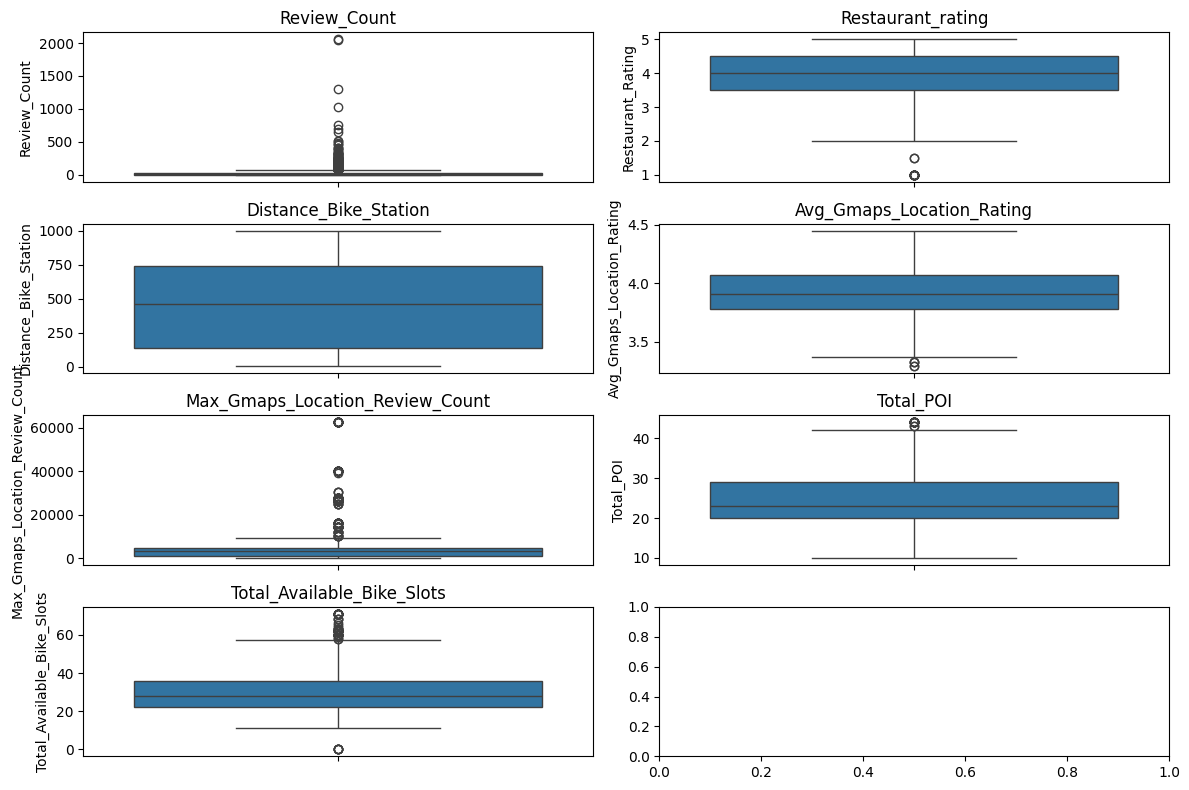

In [41]:
# Univariate Analysis 
final_df.head(5)

# Distribution of numerical columns - Review_Count, Restaurant_rating, Distance_Bike_Station, Avg_Gmaps_Location_Rating,
# Max_Gmaps_Location_Review_Count, Total_POI, Total_Available_Bike_Slots
# Distribution of categorical columns - Cuisine_Category_1, Yelp_Price_Category

# Boxplot

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Example boxplots for different columns
sns.boxplot(y='Review_Count', data=final_df, ax=axes[0])
axes[0].set_title('Review_Count')

sns.boxplot(y='Restaurant_Rating', data=final_df, ax=axes[1])
axes[1].set_title('Restaurant_rating')

sns.boxplot(y='Distance_Bike_Station', data=final_df, ax=axes[2])
axes[2].set_title('Distance_Bike_Station')

sns.boxplot(y='Avg_Gmaps_Location_Rating', data=final_df, ax=axes[3])
axes[3].set_title('Avg_Gmaps_Location_Rating')

sns.boxplot(y='Max_Gmaps_Location_Review_Count', data=final_df, ax=axes[4])
axes[4].set_title('Max_Gmaps_Location_Review_Count')

sns.boxplot(y='Total_POI', data=final_df, ax=axes[5])
axes[5].set_title('Total_POI')

sns.boxplot(y='Total_Available_Bike_Slots', data=final_df, ax=axes[6])
axes[6].set_title('Total_Available_Bike_Slots')


# Adjust layout
plt.tight_layout()

plt.savefig(r".\Visualizations\Quantitative_Analysis_Box_Plots.png")

# Show the plots
plt.show()

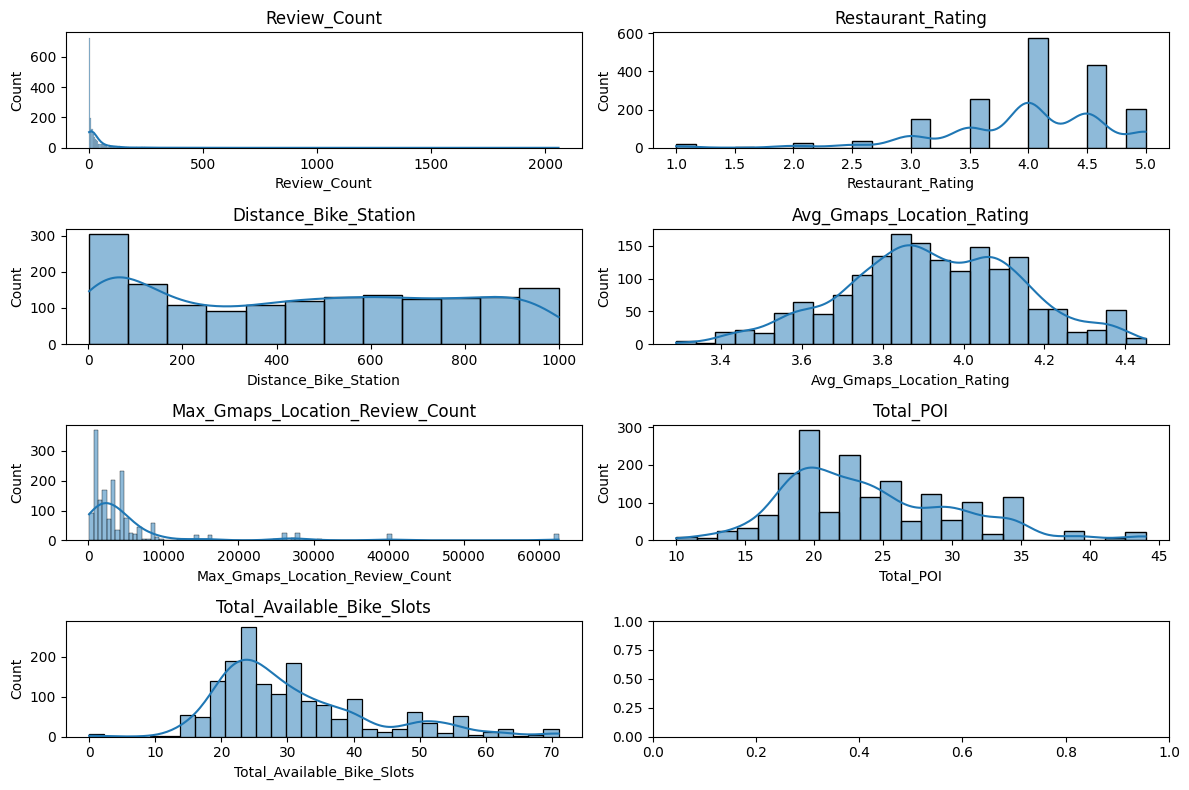

In [42]:
# Histplot

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Example boxplots for different columns
sns.histplot(x='Review_Count', data=final_df, ax=axes[0], kde=True)
axes[0].set_title('Review_Count')

sns.histplot(x='Restaurant_Rating', data=final_df, ax=axes[1], kde=True)
axes[1].set_title('Restaurant_Rating')

sns.histplot(x='Distance_Bike_Station', data=final_df, ax=axes[2], kde=True)
axes[2].set_title('Distance_Bike_Station')

sns.histplot(x='Avg_Gmaps_Location_Rating', data=final_df, ax=axes[3], kde=True)
axes[3].set_title('Avg_Gmaps_Location_Rating')

sns.histplot(x='Max_Gmaps_Location_Review_Count', data=final_df, ax=axes[4], kde=True)
axes[4].set_title('Max_Gmaps_Location_Review_Count')

sns.histplot(x='Total_POI', data=final_df, ax=axes[5], kde=True)
axes[5].set_title('Total_POI')

sns.histplot(x='Total_Available_Bike_Slots', data=final_df, ax=axes[6], kde=True)
axes[6].set_title('Total_Available_Bike_Slots')

# Adjust layout
plt.tight_layout()

plt.savefig(r".\Visualizations\Histrograms.png")

# Show the plots
plt.show()

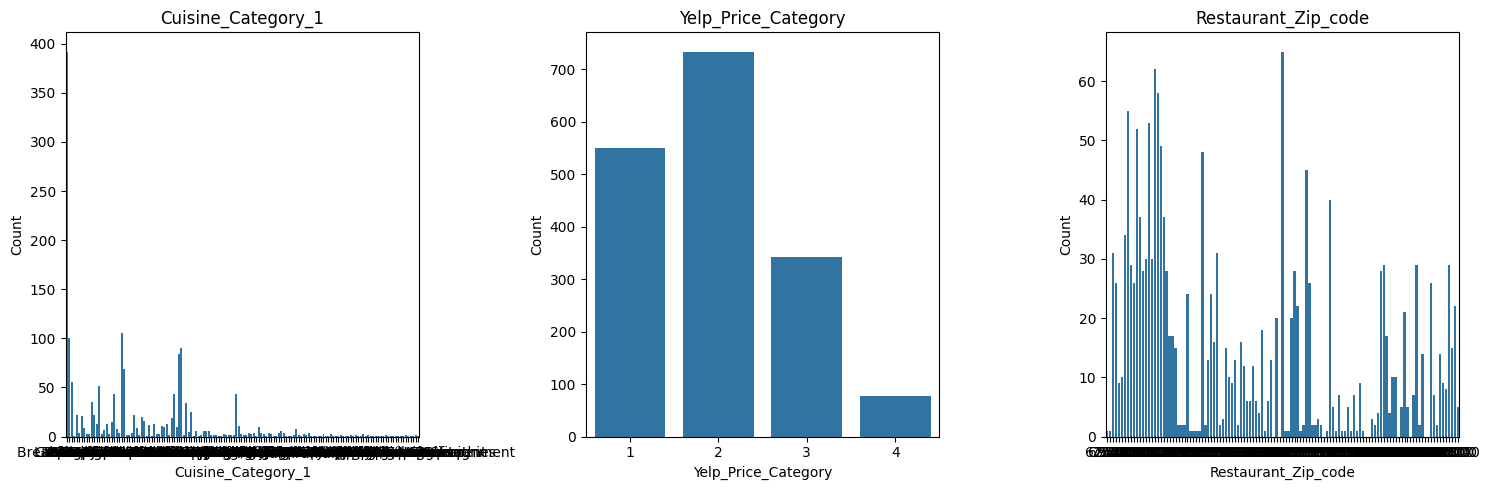

In [43]:
# Bar plot for categorical columns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))


# Loop through each categorical column and create a bar plot
for i, column in enumerate(['Cuisine_Category_1', 'Yelp_Price_Category', 'Restaurant_Zip_code']):
    sns.countplot(x=column, data=final_df, ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

plt.savefig(r".\Visualizations\Bar_Plots.png")

# Show the plots
plt.show()


C:\Users\aksha\AppData\Local\Temp\ipykernel_25276\3347605357.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette="viridis")


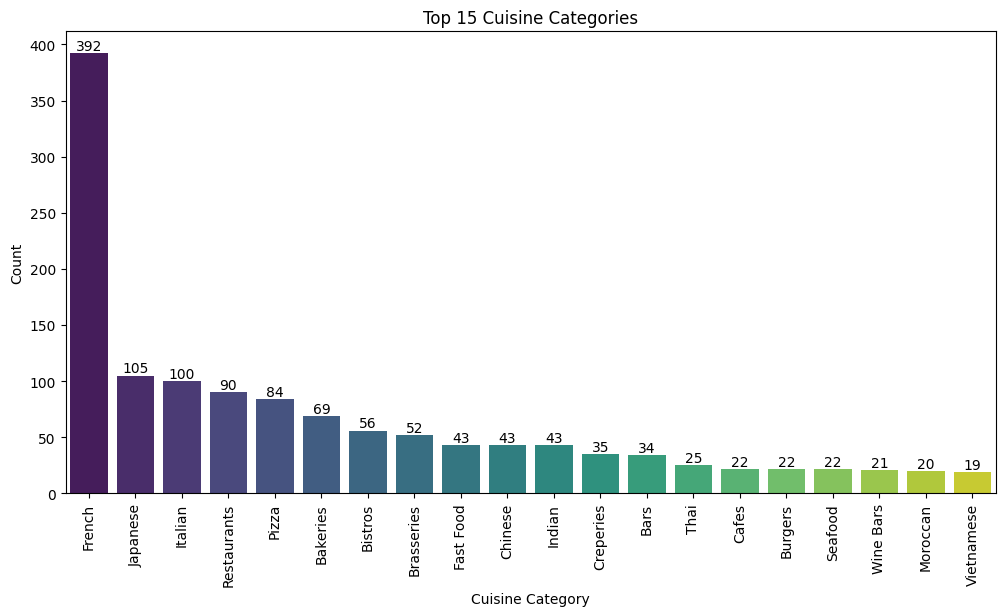

In [44]:
# Since cuisine category is not readable we will make a bar plot of top 20 categories

top_categories = final_df['Cuisine_Category_1'].value_counts().head(20)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.index, y=top_categories.values, palette="viridis")

plt.xticks(rotation=90, ha='center') 

for i, value in enumerate(top_categories.values):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Cuisine Category')
plt.ylabel('Count')
plt.title('Top 15 Cuisine Categories')

plt.savefig(r".\Visualizations\Top_Cuisines.png")


In [50]:
# Geographical plot of restaurants

# Visualize the bike stations in a geo map

color_scale = 'RdBu'

fig = px.scatter_mapbox(final_df, 
                        lat="Restaurant_Latitude", 
                        lon="Restaurant_Longitude", 
                        hover_name="Restaurant_Name", 
                        hover_data=["Review_Count", "Restaurant_Rating"],
                        color="Restaurant_Rating",
                        color_continuous_scale=color_scale,
                        size="Avg_Gmaps_Location_Rating",
                        zoom=8, 
                        height=600,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
# Majority of the stations are in the downtown area

# Save the figure as an HTML file
fig.write_html(r".\Visualizations\Restaurant_Ratings_Geo_Map.html")


In [51]:
# Geographical plot of restaurants

# Visualize the bike stations in a geo map

color_scale = 'RdBu'

fig = px.scatter_mapbox(final_df, 
                        lat="Restaurant_Latitude", 
                        lon="Restaurant_Longitude", 
                        hover_name="Restaurant_Name", 
                        hover_data=["Review_Count", "Restaurant_Rating"],
                        color="Total_POI",
                        color_continuous_scale=color_scale,
                        size="Total_POI",
                        zoom=8, 
                        height=600,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
# Majority of the stations are in the downtown area

# Save the figure as an HTML file
fig.write_html(r".\Visualizations\Total_POI_Geo_Map.html")

In [52]:
# Geographical plot of restaurants

# Visualize the bike stations in a geo map
final_df['Total_POI_No_Lodges'] = final_df['Total_POI'] - final_df['lodging']
color_scale = 'RdBu'

fig = px.scatter_mapbox(final_df, 
                        lat="Restaurant_Latitude", 
                        lon="Restaurant_Longitude", 
                        hover_name="Restaurant_Name", 
                        hover_data=["Review_Count", "Restaurant_Rating"],
                        color="Total_POI_No_Lodges",
                        color_continuous_scale=color_scale,
                        size="Total_POI_No_Lodges",
                        zoom=8, 
                        height=600,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
# Majority of the stations are in the downtown area

# Save the figure as an HTML file
fig.write_html(r".\Visualizations\Total_POI__Without_Lodges_Geo_Map.html")

In [53]:
# Geographical plot of restaurants

# Visualize the bike stations in a geo map

color_scale = 'RdBu'

fig = px.scatter_mapbox(final_df, 
                        lat="Restaurant_Latitude", 
                        lon="Restaurant_Longitude", 
                        hover_name="Restaurant_Name", 
                        hover_data=["Review_Count", "Restaurant_Rating"],
                        color="Review_Count",
                        color_continuous_scale=color_scale,
                        size="Review_Count",
                        zoom=8, 
                        height=600,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
# Majority of the stations are in the downtown area

# Save the figure as an HTML file
fig.write_html(r".\Visualizations\Restaurant_Review_Count_Geo_Map.html")

In [54]:
# Geographical plot of restaurants

# Visualize the bike stations in a geo map

color_scale = 'RdBu'

fig = px.scatter_mapbox(final_df, 
                        lat="Restaurant_Latitude", 
                        lon="Restaurant_Longitude", 
                        hover_name="Restaurant_Name", 
                        hover_data=["Review_Count", "Restaurant_Rating"],
                        color="Max_Gmaps_Location_Review_Count",
                        color_continuous_scale=color_scale,
                        size="Max_Gmaps_Location_Review_Count",
                        zoom=8, 
                        height=600,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
# Majority of the stations are in the downtown area

# Save the figure as an HTML file
fig.write_html(r".\Visualizations\Google_Map_Street_Popularity_Geo_Map.html")

In [55]:
# Choose a discrete color scale for categorical variables
color_scale = px.colors.qualitative.Set1

# Convert Yelp_Price_Category to an ordered categorical variable
final_df['Yelp_Price_Category'] = final_df['Yelp_Price_Category'].astype('category').cat.as_ordered()

fig = px.scatter_mapbox(final_df, 
                        lat="Restaurant_Latitude", 
                        lon="Restaurant_Longitude", 
                        hover_name="Restaurant_Name", 
                        hover_data=["Review_Count", "Restaurant_Rating", "Yelp_Price_Category"],
                        color="Yelp_Price_Category",
                        color_discrete_sequence=color_scale,  # Use discrete color scale
                        size="Yelp_Price_Category",
                        zoom=8, 
                        height=600,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

fig.write_html(r".\Visualizations\Yelp_Price_Category_Geo_Map.html")

c:\Users\aksha\anaconda3\envs\python_3.11.5\Lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [56]:
# Choose a discrete color scale for categorical variables
color_scale = px.colors.qualitative.Set1

# Convert Yelp_Price_Category to an ordered categorical variable
final_df['Yelp_Price_Category'] = final_df['Yelp_Price_Category'].astype('category').cat.as_ordered()

fig = px.scatter_mapbox(final_df, 
                        lat="Restaurant_Latitude", 
                        lon="Restaurant_Longitude", 
                        hover_name="Restaurant_Name", 
                        hover_data=["Review_Count", "Restaurant_Rating", "Yelp_Price_Category"],
                        color="Yelp_Price_Category",
                        color_discrete_sequence=color_scale,  # Use discrete color scale
                        size="Review_Count",
                        zoom=8, 
                        height=600,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

fig.write_html(r".\Visualizations\Restaurant_Review_Count_vs_Price_Category_Geo_Map.html")

c:\Users\aksha\anaconda3\envs\python_3.11.5\Lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



# Feature Selection using Statistical tests 

- Correlation Heatmaps - No multi-collinearity found in the data

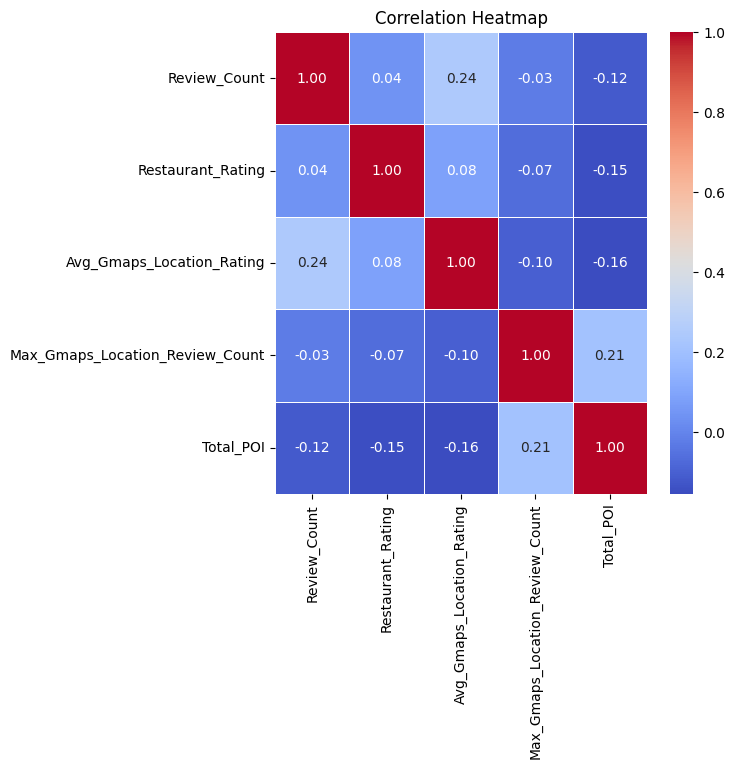

In [57]:
# Correlation Heatmap to check for multi-collineariy

final_df.head(5)
# Calculate the correlation matrix
final_df_corr_matrix = final_df[['Review_Count', 'Restaurant_Rating', 'Avg_Gmaps_Location_Rating', 
'Max_Gmaps_Location_Review_Count', 'Total_POI']].corr()

# Create a heatmap 
plt.figure(figsize=(6, 6))
sns.heatmap(final_df_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.savefig(r"Visualizations\Correlation_Heatmap.png")

# plt.show()


- Create Dependent Variable

In [59]:

import numpy as np

threshold_review_count = np.percentile(final_df['Review_Count'], 60) # Very Skewed distribution hence taking 60
threshold_rating = np.percentile(final_df['Restaurant_Rating'], 80)

# Create a new column with flags based on the conditions
final_df['Popular_Restaurant'] = ((final_df['Review_Count'] >= threshold_review_count) & 
                                  (final_df['Restaurant_Rating'] >= threshold_rating)).astype(int)

final_df[['Restaurant_Zip_code', 'Yelp_Price_Category', 'Popular_Restaurant']] = final_df[['Restaurant_Zip_code', 'Yelp_Price_Category', 'Popular_Restaurant']].astype('category')


final_df.head(5)

final_df.Popular_Restaurant.value_counts() # 20% in class 1 and 80% in class 0

# Divide the dataset into test and train prior to EDA to avoid bias in analysis owing to test set

final_df.to_csv(r'.\Data\Project_Dataset.csv', index = False)


- Drop columns with high missing value proportion or not relevant from functional standpoint

In [60]:
# Statistical Tests to be done - hence not removing the Popular Restaurant column

# Dropping columns not of relevance or very high missing values

from sklearn.model_selection import train_test_split

columns_to_drop = [
    'Restaurant_ID', 'Restaurant_Name', 'Restaurant_Latitude', 'Restaurant_Longitude',
    'Latitude', 'Longitude', 'Cuisine_Category_2', 'Cuisine_Category_3', 'Cuisine_Category_4',
    'Cuisine_Category_5', 'All_Cuisine_Category'
]


X = final_df.drop(columns=columns_to_drop, axis=1)  # Features
y = final_df['Popular_Restaurant']  # Target variable

# Split the dataset into training and testing sets with an 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the sizes of the resulting sets
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 1363
Testing set size: 341


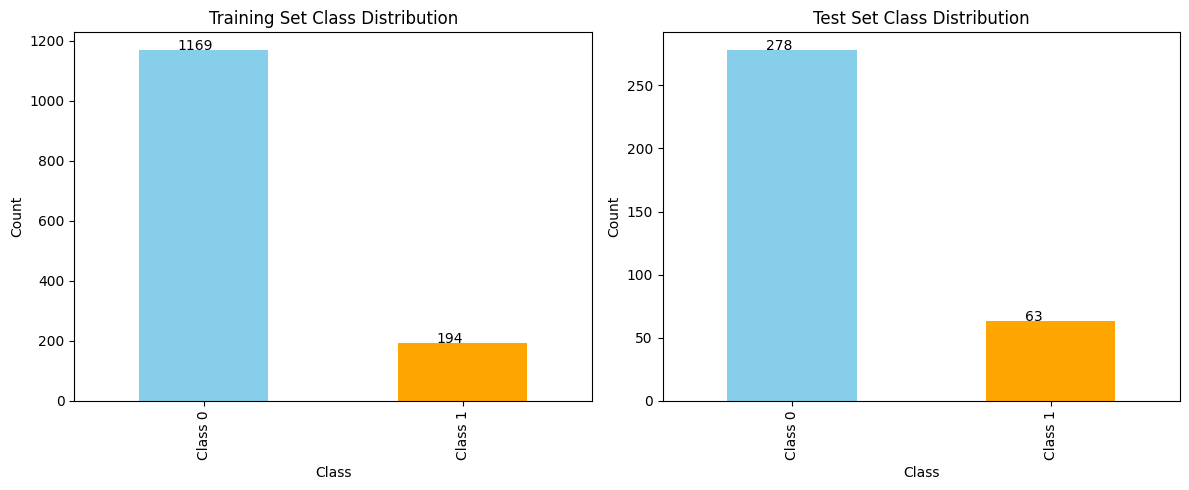

In [61]:

# Create DataFrames to make analysis easier
train_df = pd.DataFrame(data=np.column_stack((X_train, y_train)), columns=list(range(X_train.shape[1])) + ['Class'])
test_df = pd.DataFrame(data=np.column_stack((X_test, y_test)), columns=list(range(X_test.shape[1])) + ['Class'])

# Plot the distribution of class 1 and 0 in the training set
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
ax1 = train_df['Class'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Class 0', 'Class 1'])  # Add class labels to x-axis

# Add labels on top of the bars
for i, v in enumerate(train_df['Class'].value_counts()):
    ax1.text(i - 0.1, v + 0.1, str(v), color='black')

# Plot the distribution of class 1 and 0 in the test set
plt.subplot(1, 2, 2)
ax2 = test_df['Class'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Test Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Class 0', 'Class 1'])  # Add class labels to x-axis

# Add labels on top of the bars
for i, v in enumerate(test_df['Class'].value_counts()):
    ax2.text(i - 0.1, v + 0.1, str(v), color='black')

plt.tight_layout()
plt.show()

In [ ]:

# Check for NA in complete data

# Define additional types of missing values to check
missing_values_types = ['', 'NA', 'N/A', 'NaN', 'null', 'None']  # Add more if needed

# Check for missing values, including additional types
missing_values = final_df.apply(lambda col: col.isin(missing_values_types).sum())

# Display the missing values count for each column
print("Missing Values in Each Column:")
print(missing_values)

# Optionally, you can also check if there are any missing values in the entire dataset
total_missing = missing_values.sum()
if total_missing > 0:
    print("\nTotal Missing Values in the Entire Dataset:", total_missing)
else:
    print("\nNo Missing Values in the Entire Dataset")






Statistical Tests

- T-Tests

In [63]:


from scipy.stats import ttest_ind


train_indices = X_train.index  # Indices of the training set
subset_final_df = X.iloc[train_indices]

subset_final_df.drop(columns = [], inplace = True)
subset_final_df.head(5)


# Independent Sample T-test 

# Popular_Restaurant ~ Review_Count, Restaurant_Rating, Distance_Bike_Station, Avg_Gmaps_Location_Rating, Max_Gmaps_Location_Review_Count
# Total_POI, Total_Available_Bike_Slots

numerical_columns = subset_final_df.select_dtypes(include=['float64', 'int64','int32']).columns

# Perform t-tests for each column
for column in numerical_columns:
    popular_group = subset_final_df[subset_final_df['Popular_Restaurant'] == 1][column]
    not_popular_group = subset_final_df[subset_final_df['Popular_Restaurant'] == 0][column]

    t_statistic, p_value = ttest_ind(popular_group, not_popular_group)

    # Print results
    print(f"T-test for {column}:")
    print("  - T-statistic:", t_statistic)
    print("  - P-value:", p_value)

    # Interpret the results
    if p_value < 0.05:
        print(column)
        print("  - Reject the null hypothesis. There is a significant difference between groups.")
    else:
         print("  - Fail to reject the null hypothesis. There is no significant difference between groups.")

    print("\n")

# Columns to keep - 'Review_Count',	'Restaurant_Rating',	'Distance_Bike_Station',	'Avg_Gmaps_Location_Rating',	'lodging',	'shopping_mall',	'atm',	'bakery',	'bank',	'beauty_salon',	'bicycle_store',	'book_store',	'bowling_alley',	'car_dealer',	'car_repair',	'church',	'city_hall',	'clothing_store',	'convenience_store',	'courthouse',	'dentist',	'department_store',	'doctor',	'electrician',	'electronics_store',	'florist',	'furniture_store',	'gym',	'hair_care',	'home_goods_store',	'hospital',	'insurance_agency',	'jewelry_store',	'liquor_store',	'meal_delivery',	'meal_takeaway',	'parking',	'pet_store',	'pharmacy',	'police',	'post_office',	'real_estate_agency',	'restaurant',	'school',	'shoe_store',	'spa',	'store',	'supermarket',	'travel_agency',	'veterinary_care',	'Total_POI',	'Total_Available_Bike_Slots',	'Popular_Restaurant'


C:\Users\aksha\AppData\Local\Temp\ipykernel_25276\2677409855.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



T-test for Review_Count:
  - T-statistic: 9.187957328407576
  - P-value: 1.4504628772530225e-19
Review_Count
  - Reject the null hypothesis. There is a significant difference between groups.


T-test for Restaurant_Rating:
  - T-statistic: 12.048019865734634
  - P-value: 7.76605198519906e-32
Restaurant_Rating
  - Reject the null hypothesis. There is a significant difference between groups.


T-test for Distance_Bike_Station:
  - T-statistic: 3.2447629241679343
  - P-value: 0.0012040482251629155
Distance_Bike_Station
  - Reject the null hypothesis. There is a significant difference between groups.


T-test for Avg_Gmaps_Location_Rating:
  - T-statistic: 9.615625464456462
  - P-value: 3.189254207613037e-21
Avg_Gmaps_Location_Rating
  - Reject the null hypothesis. There is a significant difference between groups.


T-test for Max_Gmaps_Location_Review_Count:
  - T-statistic: -0.3626791625191844
  - P-value: 0.7169008799366124
  - Fail to reject the null hypothesis. There is no significant

- Chi-Square Tests

In [64]:
from scipy.stats import chi2_contingency

# Check association with the Cuisine Type 1 column

# Create a contingency table
contingency_table = pd.crosstab(subset_final_df['Popular_Restaurant'], subset_final_df['Cuisine_Category_1'])

# Perform chi-square test
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

# Print results
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant association between 'Popularity' and 'Cuisine_Category_1'.")
else:
    print("Fail to reject the null hypothesis. There is no significant association between 'Popularity' and 'Cuisine_Category_1'.")

Chi-square statistic: 219.13227968783946
P-value: 6.281986818439115e-06
Reject the null hypothesis. There is a significant association between 'Popularity' and 'Cuisine_Category_1'.


In [65]:
# Check association with the Zipcode

# Create a contingency table
contingency_table = pd.crosstab(subset_final_df['Popular_Restaurant'], subset_final_df['Restaurant_Zip_code'])

# Perform chi-square test
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

# Print results
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant association between 'Popularity' and 'Restaurant_Zip_code'.")
else:
    print("Fail to reject the null hypothesis. There is no significant association between 'Popularity' and 'Restaurant_Zip_code'.")

Chi-square statistic: 300.50301455274086
P-value: 9.665427867521155e-21
Reject the null hypothesis. There is a significant association between 'Popularity' and 'Restaurant_Zip_code'.


In [66]:
# Check association with the Price Category column

# Create a contingency table
contingency_table = pd.crosstab(subset_final_df['Popular_Restaurant'], subset_final_df['Yelp_Price_Category'])

# Perform chi-square test
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

# Print results
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant association between 'Popularity' and 'Price Category'.")
else:
    print("Fail to reject the null hypothesis. There is no significant association between 'Popularity' and 'Price Category'.")

Chi-square statistic: 52.809898211169234
P-value: 2.0126857657075263e-11
Reject the null hypothesis. There is a significant association between 'Popularity' and 'Price Category'.
